# Zero-Noise Extrapolation: an example workflow

This notebook is a tutorial on how to use Zero-Noise Extrapolation (ZNE) in OpenQAOA, and is intended to explain the most important configurations for working with this technique. For the matter of this tutorial, three workflows over a MaxCut problem are gonna be run. The first one, just a noiseless QAOA workflow. The second one, a noise simulated QAOA workflow. The third one, the same noise simulated QAOA workflow, but this time, mitigating the noise with ZNE.

Because ZNE implementation is done as an integration of $\href{https://mitiq.readthedocs.io/en/stable/guide/zne.html}{\text{Mitiq}}$ on OpenQAOA, more detailed tutorials can be found on the $\href{https://mitiq.readthedocs.io/en/stable/examples/examples.html}{\text{the following link}}$.

## Begin by importing necessary modules

In [1]:
# some regular python libraries
import networkx as nx
import matplotlib.pyplot as plt

# OpenQAOA imports
from openqaoa import QAOA  
from openqaoa.problems import MaximumCut
from openqaoa.backends import create_device
from openqaoa.utilities import ground_state_hamiltonian,plot_graph
from openqaoa.utilities import plot_graph

# some useful qiskit imports
from qiskit import transpile
from qiskit_aer.noise import (NoiseModel, depolarizing_error)

## Step 1: Define a problem instance

We begin by creating a problem instance for a simple MaxCut problem. For that, the NETWORKRRKRK module is gonna be used.

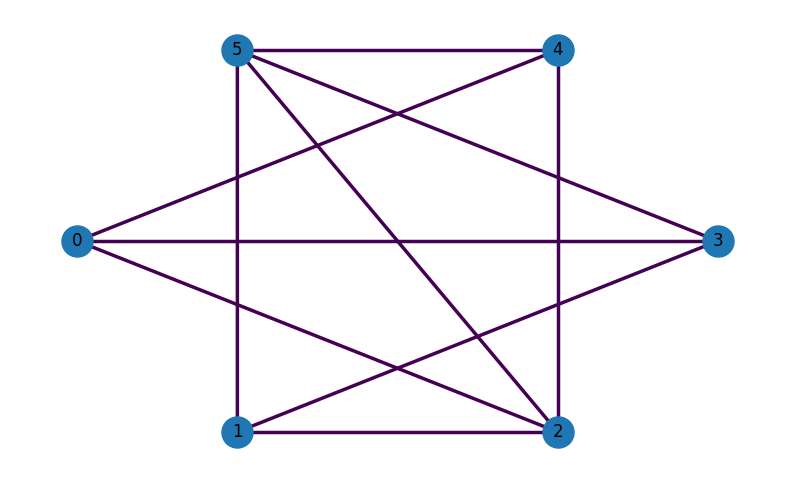

In [15]:
nodes = 6
edge_probability = 0.6
g = nx.generators.fast_gnp_random_graph(n=nodes, p=edge_probability, seed=42)

# import graph plotter from openqaoa
plot_graph(g)

# create the maximum cut instance and get its QUBO
maxcut = MaximumCut(g)
maxcut_qubo = maxcut.qubo

## Extract the exact solution for a small enough problem

In [16]:
hamiltonian =  maxcut_qubo.hamiltonian

energy, configuration = ground_state_hamiltonian(hamiltonian)
print(f"Ground State energy: {energy}, Solution/s: {configuration}")

Ground State energy: -6.0, Solution/s: ['001110', '110001']


## Step 3: Define a noise model

For a right integration with Mitiq, OpenQAOA makes a mandatory transpile of the QAOA parametric circuit to the basis gates $H$, $RX$ and $CX$. It is recommended to add noise only to that gates so as to have a succesful noise modelling.

In [17]:
# gates to add noise
one_qubit_gates = ['h','rx']
two_qubits_gates = ['cx']

def add_depolarizing_error(noise_model,probability1, probability2):
    noise_model = add_one_qubit_depolarizing_error(noise_model,probability1)
    noise_model = add_two_qubits_depolarizing_error(noise_model,probability2)
    return noise_model

def add_one_qubit_depolarizing_error(noise_model,prob):
    error = depolarizing_error(prob, 1)
    noise_model.add_all_qubit_quantum_error(error,one_qubit_gates)
    return noise_model

def add_two_qubits_depolarizing_error(noise_model,prob):
    error = depolarizing_error(prob, 2)
    noise_model.add_all_qubit_quantum_error(error, two_qubits_gates)
    return noise_model

#create the noise model
noise_model = add_depolarizing_error(NoiseModel(),0.0001989 ,0.007905)
noise_model

<NoiseModel on ['h', 'cx', 'rx']>

## Step 4: run a noiseless QAOA workflow

In [18]:
# create, configure and run the QAOA
q1 = QAOA()

qiskit_device = create_device(location='local', name='qiskit.shot_simulator')

q1.set_device(qiskit_device)

q1.set_circuit_properties(p=4, param_type='standard', init_type='ramp', mixer_hamiltonian='x')

q1.set_backend_properties(n_shots=5000,seed_simulator=1)

q1.set_classical_optimizer(method='Powell', maxiter=200, tol=0.01,maxfev=5000, optimization_progress=True, cost_progress=True, parameter_log=True)

q1.compile(maxcut_qubo)

q1.optimize()

(<Figure size 1000x800 with 1 Axes>,
 <Axes: title={'center': 'Cost history'}, xlabel='Number of function evaluations', ylabel='Cost'>)

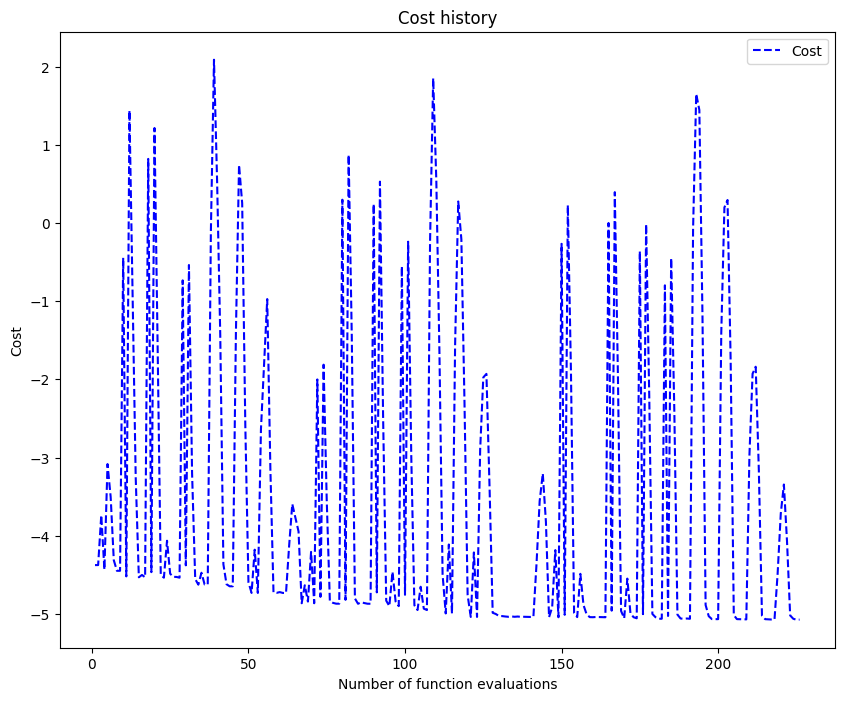

In [19]:
# access the results
opt_results1 = q1.result
opt_results1.plot_cost()

## Step 4: run a noisy QAOA workflow

In [20]:
# create, configure and run the QAOA
q2 = QAOA()

qiskit_device = create_device(location='local', name='qiskit.shot_simulator')

q2.set_device(qiskit_device)

q2.set_circuit_properties(p=4, param_type='standard', init_type='ramp', mixer_hamiltonian='x')

# here it is set the noise model
q2.set_backend_properties(n_shots=5000, noise_model=noise_model,seed_simulator=1)

q2.set_classical_optimizer(method='Powell', maxiter=200, tol=0.01,maxfev=5000, optimization_progress=True, cost_progress=True, parameter_log=True)

q2.compile(maxcut_qubo)

# it is necessary to transpile the parametric circuit with the same basis gates that has the noise model
q2.backend.parametric_circuit = transpile(q2.backend.parametric_circuit,basis_gates=["h","rx","cx"])

q2.optimize()

(<Figure size 1000x800 with 1 Axes>,
 <Axes: title={'center': 'Cost history'}, xlabel='Number of function evaluations', ylabel='Cost'>)

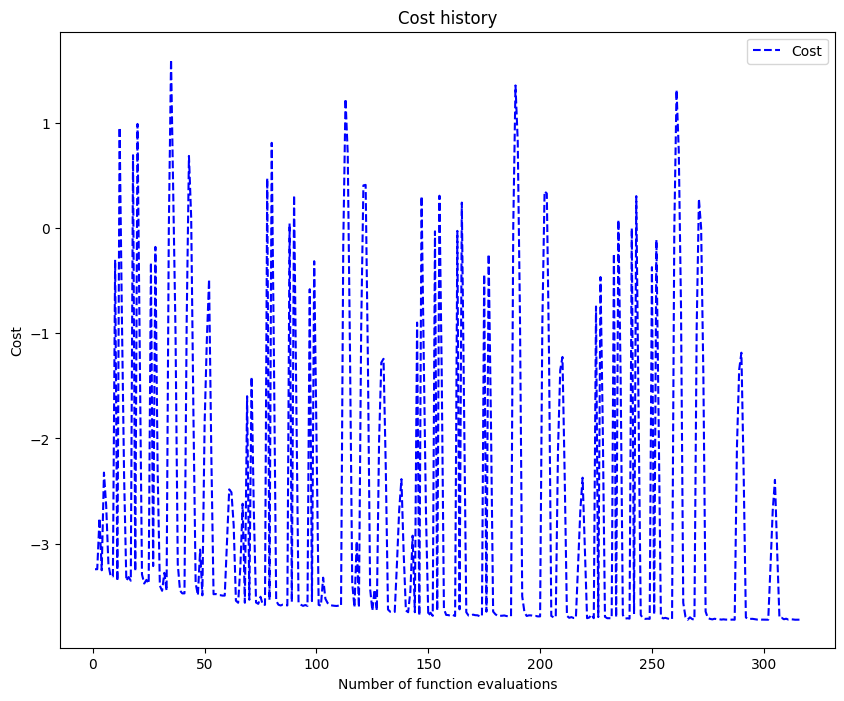

In [21]:
# access the results
opt_results2 = q2.result
opt_results2.plot_cost()

## Step 5: run a ZNE mitigated QAOA workflow

Available options to set up the ZNE with `set_error_mitigation_properties`:

- **factory**: The name of the zero-noise extrapolation method. Supported values: "Richardson", "Linear", "Poly", "Exp", "PolyExp", "AdaExp", "FakeNodes".
- **scaling**: The name of the function for scaling the noise of a quantum circuit. Supported values: "fold_gates_at_random", "fold_gates_from_right", "fold_gates_from_left".
- **scale_factors**: List[int] Sequence of noise scale factors at which expectation values should be measured. For factory = "AdaExp", just the first element of the list will be considered.
- **order**: Extrapolation order (degree of the polynomial fit). It cannot exceed len(scale_factors) - 1. Only used for factory = "Poly" or "PolyExp".
- **steps**: The number of optimization steps. At least 3 are necessary. Only used for factory = "AdaExp".

In [22]:
# create, configure and run the QAOA
q3 = QAOA()

qiskit_device = create_device(location='local', name='qiskit.shot_simulator')

q3.set_device(qiskit_device)

q3.set_circuit_properties(p=4, param_type='standard', init_type='ramp', mixer_hamiltonian='x')

# here is set the noise model
q3.set_backend_properties(n_shots=5000,seed_simulator=1,noise_model=noise_model)

q3.set_classical_optimizer(method='Powell', maxiter=100, tol=0.01,maxfev=5000, optimization_progress=True, cost_progress=True, parameter_log=True)

# here is set the ZNE
q3.set_error_mitigation_properties(error_mitigation_technique='mitiq_zne',factory = 'Richardson', scale_factors = [1,2,3])

q3.compile(maxcut_qubo)

q3.optimize()

(<Figure size 1000x800 with 1 Axes>,
 <Axes: title={'center': 'Cost history'}, xlabel='Number of function evaluations', ylabel='Cost'>)

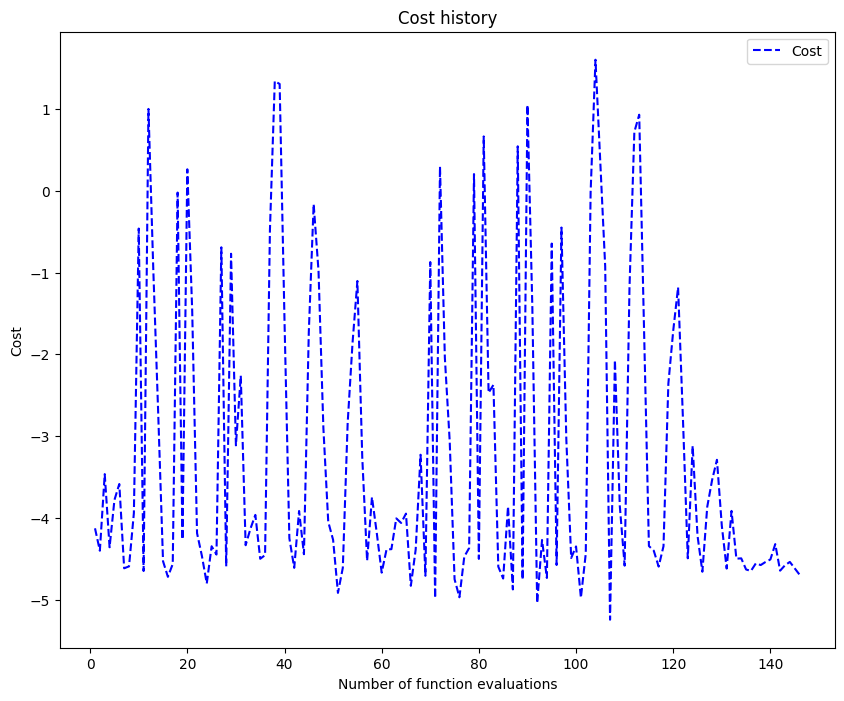

In [23]:
opt_results3 = q3.result
opt_results3.plot_cost()

## Step 6: Compare the cost plots

The resulting ZNE cost history is way more similar to the noiseless cost history. This works the same when comparing the lowest cost achieved. In some optimization problems, the optimal cost works like an useful approximate value for a particular property of the problem. In the case of Maxcut, the opposite of the resulting cost approximates the size of the maximum cut for the problem instance. That is, given a final optimal cost of $-5$, a good approximation for the maximum cut size is $5$. Because ZNE gets succeed when approximating the optimal cost, it can be used for the problems where this information could help in getting the optimal solution.

(<Figure size 700x700 with 1 Axes>,
 <Axes: title={'center': 'Cost history'}, xlabel='Number of function evaluations', ylabel='Cost'>)

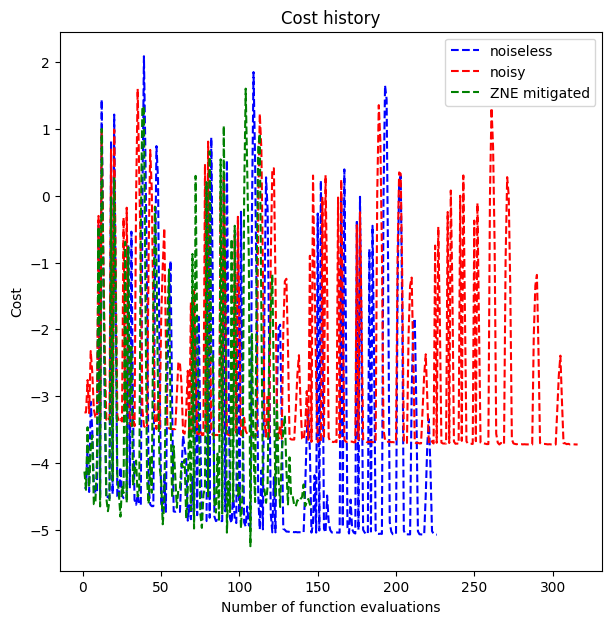

In [24]:
fig, ax = plt.subplots(figsize=(7,7))
opt_results1.plot_cost(figsize=(7,7),color='blue',label='noiseless',ax=ax)
opt_results2.plot_cost(figsize=(7,7),color='red',label='noisy',ax=ax)
opt_results3.plot_cost(figsize=(7,7),color='green',label='ZNE mitigated',ax=ax) 

## Advanced options

In QAOA, the observable of interest $X$ is the cost, which is obtained from the bitstrings measurements of the quantum ansatz and used by the optimizer. For each of the $n$ optimizations of the QAOA workflow, an iteration of ZNE will be done before, resulting in $n$ extrapolated costs.

In `backend.result_factory_objs` , the $n$ extrapolations can be accesed.

AMOUNT OF EXTRAPOLATIONS:  146
-----
EXTRAPOLATED COST NUMBER  1


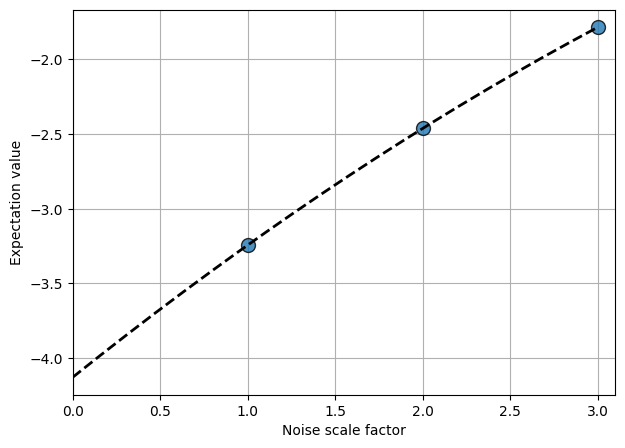

-----
...


In [33]:
print('AMOUNT OF EXTRAPOLATIONS: ',len(q3.backend.result_factory_objs))
extrapolated_costs = q3.backend.result_factory_objs[0:1]
for i,extrapolated_cost in enumerate(extrapolated_costs):
    print('-----')
    print('EXTRAPOLATED COST NUMBER ',i+1)
    fit=extrapolated_cost.plot_fit()
    plt.close()
    display(fit)
print('-----')
print('...')